<a href="https://colab.research.google.com/github/ju-ki/pytorch_basic/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

Extracting ./data/cifar-10-python.tar.gz to ./data
データの数: 10000



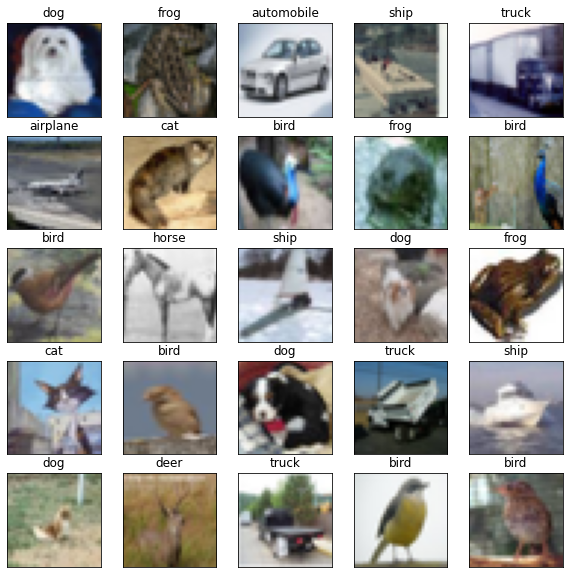

In [2]:
cifar10_data = CIFAR10(root="./data", train=False, download=True,
                       transform=transforms.ToTensor())
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データの数:", len(cifar10_data))

n_image = 25
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = dataiter.next()

plt.figure(figsize=(10, 10))
for i in range(n_image):
  plt.subplot(5, 5, i+1)
  plt.imshow(np.transpose(images[i], (1, 2, 0)))
  label = cifar10_classes[labels[i]]
  plt.title(label)
  plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  
plt.show()

Files already downloaded and verified
データの数: 10000


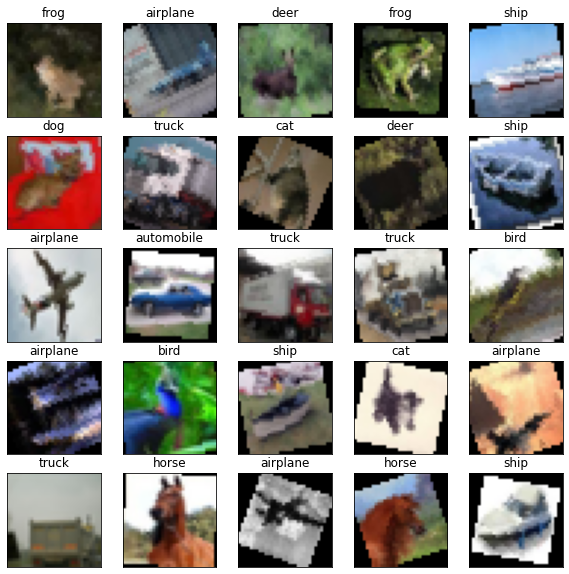

In [3]:
transform = transforms.Compose([transforms.RandomAffine([-30, 30],  scale=(0.8, 1.2)), 
                                transforms.ToTensor()])

cifar10_data = CIFAR10(root="./data",
                       train=False,download=True,
                       transform=transform)
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データの数:", len(cifar10_data))

n_image = 25
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = dataiter.next()

plt.figure(figsize=(10, 10))
for i in range(n_image):
  plt.subplot(5, 5, i+1)
  plt.imshow(np.transpose(images[i], (1, 2, 0)))
  label = cifar10_classes[labels[i]]
  plt.title(label)
  plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  
plt.show()

In [4]:
affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))
flip = transforms.RandomHorizontalFlip(p=0.5)
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])

cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 256)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

net = Net()
net.cuda()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [7]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
x_test, t_test = iter(test_loader).next()
x_test, t_test = x_test.cuda(), t_test.cuda()
for i in range(20):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.765880581363083 Loss_Test: 1.511905550956726
Epoch: 1 Loss_Train: 1.5491973442189835 Loss_Test: 1.3305294513702393
Epoch: 2 Loss_Train: 1.472205289794356 Loss_Test: 1.2311400175094604
Epoch: 3 Loss_Train: 1.4291054989065965 Loss_Test: 1.2100404500961304
Epoch: 4 Loss_Train: 1.3893717803308725 Loss_Test: 1.2524125576019287
Epoch: 5 Loss_Train: 1.365828310284773 Loss_Test: 1.190205454826355
Epoch: 6 Loss_Train: 1.341239148546058 Loss_Test: 1.1222000122070312
Epoch: 7 Loss_Train: 1.3175148539378514 Loss_Test: 1.1249217987060547
Epoch: 8 Loss_Train: 1.301117316307619 Loss_Test: 1.1339538097381592
Epoch: 9 Loss_Train: 1.2866944137893979 Loss_Test: 1.1498881578445435
Epoch: 10 Loss_Train: 1.2708201918303204 Loss_Test: 1.162190556526184
Epoch: 11 Loss_Train: 1.2606652914105778 Loss_Test: 1.1311919689178467
Epoch: 12 Loss_Train: 1.2511831223964691 Loss_Test: 1.1100695133209229
Epoch: 13 Loss_Train: 1.2361437515224643 Loss_Test: 1.1680855751037598
Epoch: 14 Loss_Train: 1.

In [8]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 62.129999999999995%


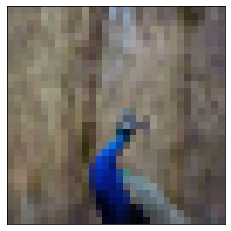

正解: bird 予測結果: bird


In [9]:
cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = dataiter.next()  # サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

net.eval()  # 評価モード
x, t = images.cuda(), labels.cuda()  # GPU対応
y = net(x)
print("正解:", cifar10_classes[labels[0]],
      "予測結果:", cifar10_classes[y.argmax().item()])